<a href="https://colab.research.google.com/github/xslittlemaggie/Machine-Learning-Projects/blob/master/Cells_Classification_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of Cells Using Logistic Regression

## **Step 0**: Import Libraries

In [0]:
# file preprocessing
import urllib
import io
import tarfile
import os

# dataFrame preprocessing and data computation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

# model building, confusion matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


## **Step 1**: About The Dataset

The dataset consists of a total of over 12, 000 cells with 2 categories:

- **SQNC** (sample size = 2,000): sequential category

- **COMB** (sample size = 10,000): combinational category 




| Device | param1 | param2 | param3 | param4 | param5 | ...... | ...... | param13 |
|--------|--------|--------|--------|--------|--------|--------|--------|---------|
|   10   |    6   |    6   |    3   |    3   |    5   |        |        |    2    |
|   10   |    8   |    3   |    2   |    4   |    4   |    2   |    3   |    6    |
|   20   |    7   |    3   |    2   |    4   |    4   |    2   |    3   |    2    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|   20   |    7   |    3   |    2   |    4   |    5   |    2   |    3   |    2    |


Entire dataset consists of 12,000 such tables labelled as **COMB** or **SQNC**.

## **Step 2**: Load the dataset and Labels

In [0]:
#Download dataset
def download_dataset():
    gh_url = 'https://github.com/srohit0/mida/raw/master/data/2classes.tar.gz'

    response    = urllib.request.urlopen(gh_url)
    tar_gz_file = io.BytesIO(response.read())
    
    return tar_gz_file

tar_decoded_contents = download_dataset().read()

In [0]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 351; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
feature_indices = (0,2,5,8,11)

def load_one_cell(encoded_cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    cell_mat  = np.loadtxt(io.StringIO(encoded_cell_file.decode()), dtype=np.float32, ndmin=2)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

In [4]:
def load_cells(): 
    tar_contents = io.BytesIO(tar_decoded_contents)

    tarFileObj = tarfile.open(fileobj=tar_contents, mode="r:gz")
    cell_files = tarFileObj.getmembers()
    
    dataset    = np.zeros(shape=(len(cell_files), max_devices_per_cell, 
                                 feature_per_device), dtype=np.float32)
    labels     = [[0.0, 0.0]]*len(cell_files)

    cell_index = 0
    comb_indices = []
    sqnc_indices = []
    for cell_file_name in cell_files:

        cell_file = tarFileObj.extractfile(cell_file_name)
        # ignore dirs etc
        if ( cell_file == None ):
            continue;

        try:

            cell_label = os.path.split(os.path.dirname(cell_file_name.name))[1]
            cell_data  = load_one_cell(cell_file.read())
        
            cell_rows = cell_data.shape[0]
            cell_cols = cell_data.shape[1]
            dataset[cell_index, :cell_rows, :cell_cols] = cell_data
            if ( cell_label == 'COMB'):
                comb_indices.append(cell_index)
                labels[cell_index] = [1.0, 0.0] 
            else:
                sqnc_indices.append(cell_index)
                labels[cell_index] = [0.0, 1.0] 

            cell_index = cell_index + 1
            
        except IOError as e:
            print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
    tarFileObj.close()

    dataset = dataset[0:cell_index, :, :]
    labels  = labels [0:cell_index]
    
    comb_dataset = [dataset[i] for i in comb_indices]
    comb_dataset = np.array(comb_dataset)
    sqnc_dataset = [dataset[i] for i in sqnc_indices]
    sqnc_dataset = np.array(sqnc_dataset)

    return comb_dataset, sqnc_dataset, dataset, np.array(labels)

comb_dataset, sqnc_dataset, dataset, labels = load_cells()


print('COMB  dataset: shape=', comb_dataset.shape, ', Mean=', np.mean(comb_dataset), ', sigma=', np.std(comb_dataset))
print('SQNC  dataset: shape=', sqnc_dataset.shape, ', Mean=', np.mean(sqnc_dataset), ', sigma=', np.std(sqnc_dataset))
print('TOTAL dataset: shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))

COMB  dataset: shape= (10096, 351, 5) , Mean= 0.6869385 , sigma= 2.9570189
SQNC  dataset: shape= (2096, 351, 5) , Mean= 1.3690326 , sigma= 4.679745
TOTAL dataset: shape= (12192, 351, 5) , Mean= 0.8042017 , sigma= 3.3274512


In [5]:
comb_dataset[0].shape

(351, 5)

## **Step 3**: Data Preprocessing

- Randomize dataset

- Visualize dataset

- Reshape the dataset from **351 X 5** into **1755**

- Normalize the dataset

- Split the dataset into training (80%) and validation (20%) datasets

### 1). Randomize dataset

In [0]:
# Randomize comb & sqnc dataset
np.random.shuffle(comb_dataset)
np.random.shuffle(sqnc_dataset)

In [7]:
# randomize dataset and labels together to keep'em in sync.
def randomize(dataset, labels):
  permutation      = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels  = labels[permutation]
  return shuffled_dataset, shuffled_labels

# randomize dataset
dataset, labels = randomize(dataset, labels)

print('Full dataset: no. of cells=', dataset.shape, 'Min=', np.min(dataset), 'Max=',np.max(dataset), 
      'Mean=', np.mean(dataset), 'Sigma=', np.std(dataset))

Full dataset: no. of cells= (12192, 351, 5) Min= 0.0 Max= 50.0 Mean= 0.8042012 Sigma= 3.3274515


### 2). Visualize Dataset

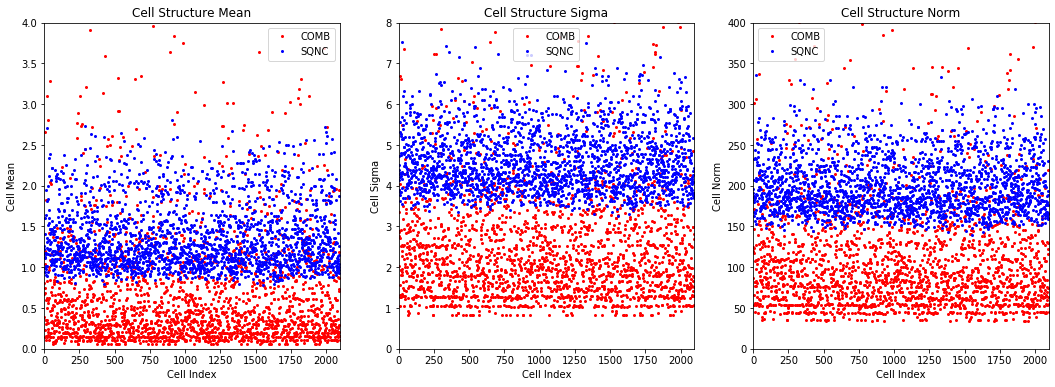

In [8]:
# Frobenius norm of matrices
comb_norms = [np.linalg.norm(cell) for cell in comb_dataset]
sqnc_norms = [np.linalg.norm(cell) for cell in sqnc_dataset]

comb_mean  = [np.mean(cell) for cell in comb_dataset]
sqnc_mean  = [np.mean(cell) for cell in sqnc_dataset]

comb_sigma = [np.std(cell) for cell in comb_dataset]
sqnc_sigma = [np.std(cell) for cell in sqnc_dataset]

comb_size = comb_dataset.shape[0]
sqnc_size = sqnc_dataset.shape[0]

plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
#plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,4)
plt.plot([i for i in range(comb_size)], comb_mean, 'ro', label='COMB', marker='o', markersize=2)
plt.plot([i for i in range(sqnc_size)], sqnc_mean, 'bo', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Mean')
plt.xlabel('Cell Index')
plt.ylabel('Cell Mean')
plt.legend()

plt.subplot(1, 3, 2)
#plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,8)
plt.plot([i for i in range(comb_size)], comb_sigma, 'ro', label='COMB', marker='o', markersize=2)
plt.plot([i for i in range(sqnc_size)], sqnc_sigma, 'bx', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Sigma')
plt.xlabel('Cell Index')
plt.ylabel('Cell Sigma')
plt.legend()

plt.subplot(1, 3, 3)
#plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,400)
plt.plot([i for i in range(comb_size)], comb_norms, 'ro', label='COMB', marker='o', markersize=2)
plt.plot([i for i in range(sqnc_size)], sqnc_norms, 'bo', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Norm')
plt.xlabel('Cell Index')
plt.ylabel('Cell Norm')
plt.legend()

plt.show()
plt.close("all")

### 3). Reformat Dataset from **351 X 5** into **1755** for modeling training

In [0]:
def reformat(dataset):
    dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))
    return dataset

dataset = reformat(dataset)

### 4). Normalize Dataset

In [10]:
# normalize the dataset between 0 and 1.
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

print('Min=', np.min(dataset), 'Max=',np.max(dataset), 'Mean=',np.mean(dataset), 'sigma=', np.std(dataset))
print('Dataset size', dataset.shape)
#print('dataset feature min vector = ', np.min(dataset, axis=0))
#print('dataset feature max vector = ', np.max(dataset, axis=0))

Min= 0.0 Max= 1.0 Mean= 0.016084053 sigma= 0.06654901
Dataset size (12192, 1755)


### 5).  Split the dataset into training and validation datasets

- Training dataset : 80%

- Validation dataset : 20%

In [11]:
# training dataset percentage is 80%
def divide_dataset(dataset, labels):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    train_X = dataset[:train_index, :]
    train_Y = labels[:train_index,:]
    val_X = dataset[train_index:,:]
    val_Y = labels[train_index:,:]
    
    return train_X, train_Y, val_X, val_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset, labels)

train_Y = train_Y[:, 0:1]
valid_Y = valid_Y[:, 0:1]
print('Training dataset: {}'.format(train_X.shape[0]))
print('Validation dataset: {}'.format(valid_X.shape[0]))

Training dataset: 9753
Validation dataset: 2439


## **Step 4**: How the final Dataset look like

After all the transformation, reshape, and normalization. The final dataset is a 2D Matrix, with 1755 features and 1 target variable. It is the dataframe we are familar with when we conduct Machine Learning, or statistics modeling.

### 1). The training dataset

The final training dataset is a 2D Matrix:

- 1755 Number of features: 

- 1 Target variable (is_COMB): 

  0 : No
  
  1 : Yes

In [12]:
train_df = pd.concat([pd.DataFrame(train_X), pd.DataFrame(train_Y, columns = ['is_COMB'])], axis = 1)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,is_COMB
0,0.2,0.10,0.06,0.02,0.02,0.2,0.14,0.30,0.02,0.02,0.2,0.14,0.30,0.02,0.02,0.2,0.36,0.20,0.02,0.02,0.2,0.34,0.32,0.02,0.02,0.2,0.28,0.08,0.14,0.02,0.2,0.30,0.22,0.02,0.02,0.2,0.26,0.24,0.02,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2,0.16,0.18,0.02,0.02,0.2,0.12,0.06,0.02,0.02,0.2,0.08,0.14,0.16,0.02,0.2,0.22,0.10,0.08,0.02,0.2,0.22,0.24,0.12,0.02,0.4,0.20,0.10,0.04,0.04,0.4,0.20,0.14,0.04,0.04,0.4,0.20,0.18,0.04,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.2,0.18,0.10,0.02,0.02,0.2,0.20,0.16,0.02,0.02,0.2,0.20,0.16,0.02,0.02,0.2,0.08,0.12,0.02,0.02,0.2,0.08,0.12,0.02,0.02,0.2,0.06,0.14,0.02,0.02,0.2,0.06,0.14,0.02,0.02,0.2,0.20,0.18,0.14,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.2,0.06,0.16,0.02,0.02,0.2,0.06,0.16,0.02,0.02,0.2,0.06,0.16,0.02,0.02,0.2,0.14,0.18,0.02,0.02,0.2,0.14,0.18,0.02,0.02,0.2,0.14,0.18,0.02,0.02,0.2,0.14,0.18,0.02,0.02,0.2,0.14,0.18,0.02,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,0.2,0.14,0.10,0.02,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
train_X.shape

(9753, 1755)

### 2). The validation dataset

In [14]:
valid_df = pd.concat([pd.DataFrame(valid_X), pd.DataFrame(valid_Y, columns = ['is_COMB'])], axis = 1)
valid_df.shape

(2439, 1756)

## **Step 5**: Model Building: Logistic Regression

In [15]:
lr = LogisticRegression()
lr.fit(train_X, train_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## **Step 6**: Model Evaluation

- Accuracy

- Confusion Matrix, ROC_AUC

### 1). Accuracy (= score from Sklearn Logistic Regression)

How many are predicted right:

- Positive --> positive

- Negative --> negative

In [16]:
score_train = lr.score(train_X, train_Y)
score_valid = lr.score(valid_X, valid_Y)

print("The train acc: {:.5f}".format(score_train))
print("The validation acc: {:.5f}".format(score_valid))

The train acc: 0.99733
The validation acc: 0.99508


In [17]:
COMB_pect = train_df.is_COMB.value_counts()/len(train_df)

COMB_pect

1.0    0.828873
0.0    0.171127
Name: is_COMB, dtype: float64

Since the dataset is imbalanced (83% COMB vs 17 % SQNC). The accurary is not a good evaluation of the model performance. Next, I will use the confusion matrix, ROC_AUC to evaluate the model performance.

### 2). Confusion Matrix & ROC_AUC

About the Confusion Matrix:

- **4 Major Elements**:

  - TP (True Positive): right, the ture label is positive

  - FP (False Positive): wrong, the ture label is negative

  - TN (True Negative): right, the true label is negative

  - FN (False Negative): wrong, the true label is positive


 - **Recall vs Precision --> F1-Score**:
 
  - **F1-Score = (2 * R * P)/(R + P)**

  - Recall = TP / (TP + FN) : Among all the true postive, how many are identified 

  - Prevision = TP / (TP + FP) : Among all the identified positive, how many are true


- **RPR vs FPR --> ROC-AUC**:

  - **ROC = TPR/FPR** (We want the TPR large, and the FPR small)

  - TPR (= Recall) = TP / (TP + FN) : Among all the true postive, how many are identified 

  - FPR = FP / (TN + FP) : Among all the true negative, how many are predicted as true

  

  The rate are determined when we have different thresholds



#### a). The confusion Matrix

In [0]:
y_pred = lr.predict(valid_X)

In [19]:
cnf_matrix = confusion_matrix(valid_Y, y_pred)
cnf_matrix

array([[ 423,    4],
       [   8, 2004]])

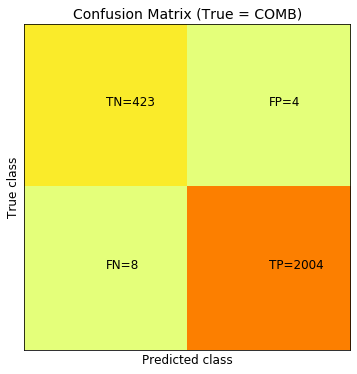

In [20]:
def plot_confusion_matrix(cm, title = "Confusion matrix", cmap = plt.cm.Wistia):
  """
  This function prints and plots the confusion matrix
  """
  plt.figure(figsize = (6, 6))
  plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Wistia) # plt.cm.Wistia
  plt.title("Confusion Matrix (True = COMB)", size = 14)
  plt.xlabel('Predicted class', size = 12)
  plt.ylabel('True class', size = 12)
  plt.xticks([])
  plt.yticks([])
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
    for j in range(2):
      plt.text(j, i, str(s[i][j]+ "=" + str(cm[i][j]) ), size = 12)
  #plt.savefig('cnf_plot')
  plt.show()
plot_confusion_matrix(cnf_matrix, title = "Confusion matrix", cmap = plt.cm.Wistia) # plt.cm.Blues

In [21]:
report = classification_report(valid_Y, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       427
         1.0       1.00      1.00      1.00      2012

    accuracy                           1.00      2439
   macro avg       0.99      0.99      0.99      2439
weighted avg       1.00      1.00      1.00      2439



#### b). ROC & AUC

The value of AUC -> [0.5, 1], the larger the better.

ROC ~ TPR vs FPR

- **TPR (True positive rate)= Recall: the larger the better**

  - TP/(TP + FN) = 2008/(2008 + 8.) = 99.6%


- **FPR (False positive rate): the smaller the better)**

  - FP/(FP + TN) = 2/(2 + 421.) = 0.47%

In [0]:
y_predict_prob = lr.predict_proba(valid_X)
y_predict = y_predict_prob[:, 1]

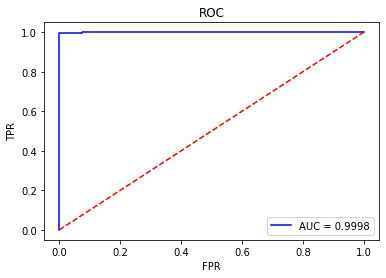

In [23]:
fpr, tpr, threshold = roc_curve(valid_Y, y_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, "b", label = "AUC = %0.4f"%roc_auc)
plt.title("ROC")
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc = "best")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [24]:
roc_auc_score = roc_auc_score(valid_Y, y_predict)
print("The roc_auc_score: {:.5f}".format(roc_auc_score))


The roc_auc_score: 0.99977


## **Step 7**: Conclusion

From the above discussion, we reach below indicators, the model performs well:

- Accuracy: 0.99344

- ROC_AUC_Score (**TPR** vs **FPR**): 0.9996

- F-1 Score (The combination of the **Recall** and **Precision**): 0.99
